# Compreendendo o problema:

### Dataset: https://www.kaggle.com/datasets/rajyellow46/wine-quality/data

### Artigo: https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377

### Etapas necessárias para criar um modelo de classificação eficiente.

Segundo a metodologia CRISP-DM:
1. Compreensão do negócio
2. Entendimento dos dados
2. Preparação dos dados
3. Modelagem dos dados
4. Avaliação do Modelo
5. Deployment

https://www.escoladnc.com.br/blog/data-science/metodologia-crisp-dm/

In [209]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn import metrics
from sklearn.model_selection import (StratifiedKFold, cross_validate, train_test_split, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# ignorar warnings
warnings.filterwarnings('ignore')

# Entendendo os dados

In [210]:
# definindo o caminho para os drives
os.listdir()
FILEPATH = 'IA Infnet/IA para classificação/winequalityN.csv'
FILENAME = 'winequalityN.csv'

# carregando os dados
data = pd.read_csv(os.path.join(FILENAME))
data.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [211]:
# modificando os nomes das colunas
data.columns = data.columns.str.replace(' ', '_')

In [212]:
# Gerando o relatório Ydata Profiling
profile = ProfileReport(data, title="Ydata Profiling Report")
# profile

### Descrevendo as variáveis presentes na base

In [213]:
# Tipos de dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [214]:
# Tipos de variáveis
for column in data.columns:
    if data[column].dtype == float:
        print(f'A variável {column} é contínua.')
    else:
        print(f'A variável {column} é categórica.')

A variável type é categórica.
A variável fixed_acidity é contínua.
A variável volatile_acidity é contínua.
A variável citric_acid é contínua.
A variável residual_sugar é contínua.
A variável chlorides é contínua.
A variável free_sulfur_dioxide é contínua.
A variável total_sulfur_dioxide é contínua.
A variável density é contínua.
A variável pH é contínua.
A variável sulphates é contínua.
A variável alcohol é contínua.
A variável quality é categórica.


# Preparando os dados

### Tratando os dados nulos

In [215]:
# verificando os dados nulos
data.isna().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [216]:
data.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6487.000000       6489.000000  6494.000000     6495.000000   
mean        7.216579          0.339691     0.318722        5.444326   
std         1.296750          0.164649     0.145265        4.758125   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6495.000000          6497.000000           6497.000000  6497.000000   
mean      0.056042            30.525319            115.744574     0.994697   
std       0.035036            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6488.000000  6493.000000  6497.000000  6497.000000  
mean      3.218395     0.531215    10.491801     5.818378  
std       0.160748     0.148814     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

Como não houve qualquer orientação com relação ao tratamento dos dados nulos das variáveis, optamos por seguir a seguinte regra:
- variáveis com dados iguais a 0: substituir os nulos por zero;
- variáveis sem dados iguais a zero: substituir os nulos pela média da variável.

In [217]:
# eliminando os valores nulos de fixed_acidity pela média
mean_fa = data.fixed_acidity.mean()

data.loc[data.fixed_acidity.isnull(),'fixed_acidity'] = mean_fa

In [218]:
# eliminando os valores nulos de volatile_acidity pela média
mean_va = data.volatile_acidity.mean()

data.loc[data.volatile_acidity.isnull(),'volatile_acidity'] = mean_va

In [219]:
# eliminando os valores nulos de citric_acid por 0
data.loc[data.citric_acid.isnull(),'citric_acid'] = 0

In [220]:
# eliminando os valores nulos de residual_sugar pela média
mean_rs = data.residual_sugar.mean()

data.loc[data.residual_sugar.isnull(),'residual_sugar'] = mean_rs

In [221]:
# eliminando os valores nulos de chlorides pela média
mean_ch = data.chlorides.mean()

data.loc[data.chlorides.isnull(),'chlorides'] = mean_ch

In [222]:
# eliminando os valores nulos de pH pela média
mean_pH = data.pH.mean()

data.loc[data.pH.isnull(),'pH'] = mean_pH

In [223]:
# eliminando os valores nulos de sulphates pela média
mean_su = data.sulphates.mean()

data.loc[data.sulphates.isnull(),'sulphates'] = mean_su

In [224]:
# Conferindo se todos os nulos foram tratados
data.isna().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [225]:
data.type.describe()

count      6497
unique        2
top       white
freq       4898
Name: type, dtype: object

### Criando a variável "opinion" e descartando "quality"

In [226]:
# criando a variável 'opinion'
data['opinion'] = data.quality.apply(lambda x: 1 if x > 5 else 0)
data['opinion'].value_counts()

1    4113
0    2384
Name: opinion, dtype: int64

In [227]:
# descartando a variável 'quality'
data.drop('quality', axis=1, inplace=True)

In [228]:
data.head()

type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  opinion  
0       0.45      8.8        1  
1       0.49      9.5        1  
2       0.44     10.1        1  
3       0.40      9.9        1  
4       0.40      9.9        1

Seguindo a orientação dos pesquisadores, como os dois tipos de vinhos são muito diferentes, separaremos o dataset em dois, um para o vinho branco, outro para o vinho tinto.

In [229]:
# Criando o dataset de vinhos brancos
white_dt = data[data.type == 'white']
white_dt = white_dt.drop('type', axis = 1)

In [230]:
# Criando o dataset de vinhos tintos
red_dt = data[data.type == 'red']
red_dt = red_dt.drop('type', axis = 1)

### Plotando histogramas para visualizar as variáveis nos três datasets

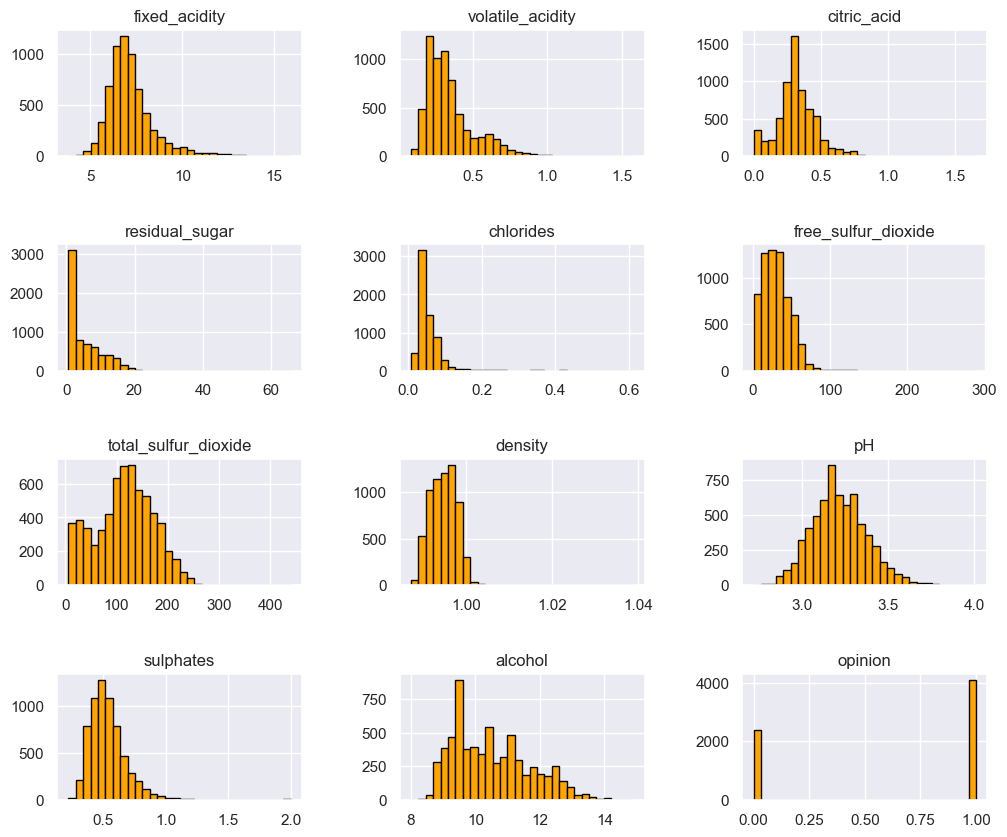

In [231]:
data.hist(figsize=(12, 10), bins=30, edgecolor="black",color='orange')
plt.subplots_adjust(hspace=0.7, wspace=0.4)

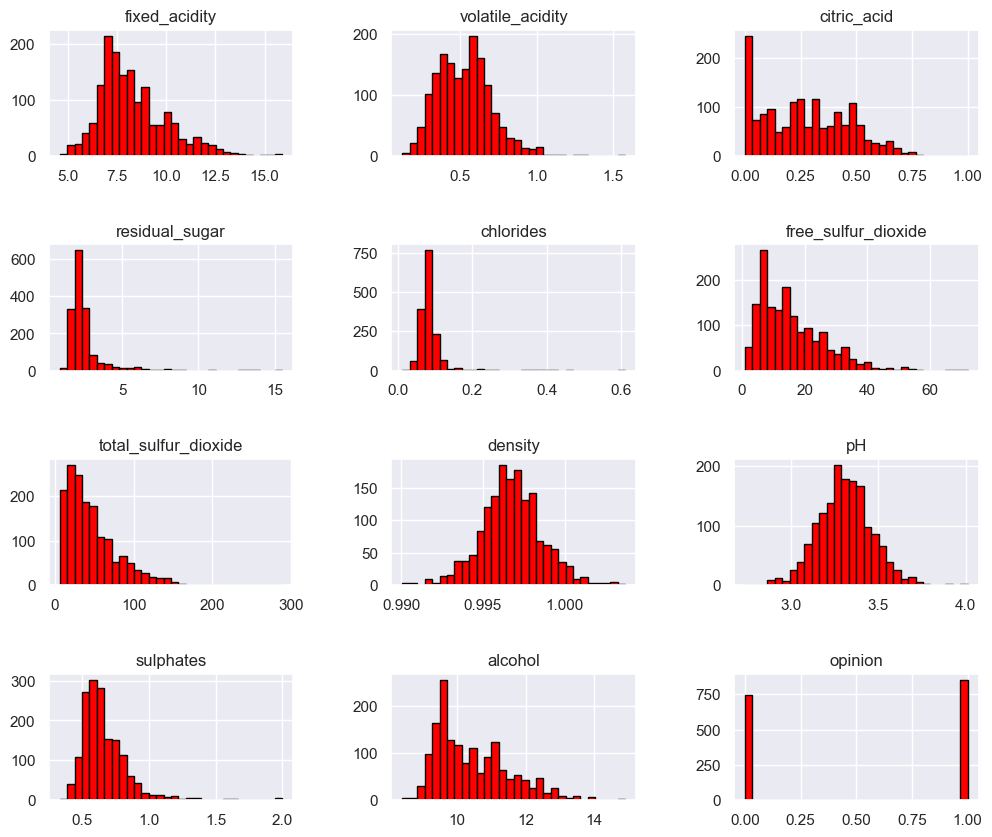

In [232]:
red_dt.hist(figsize=(12, 10), bins=30, edgecolor="black",color='red')
plt.subplots_adjust(hspace=0.7, wspace=0.4)

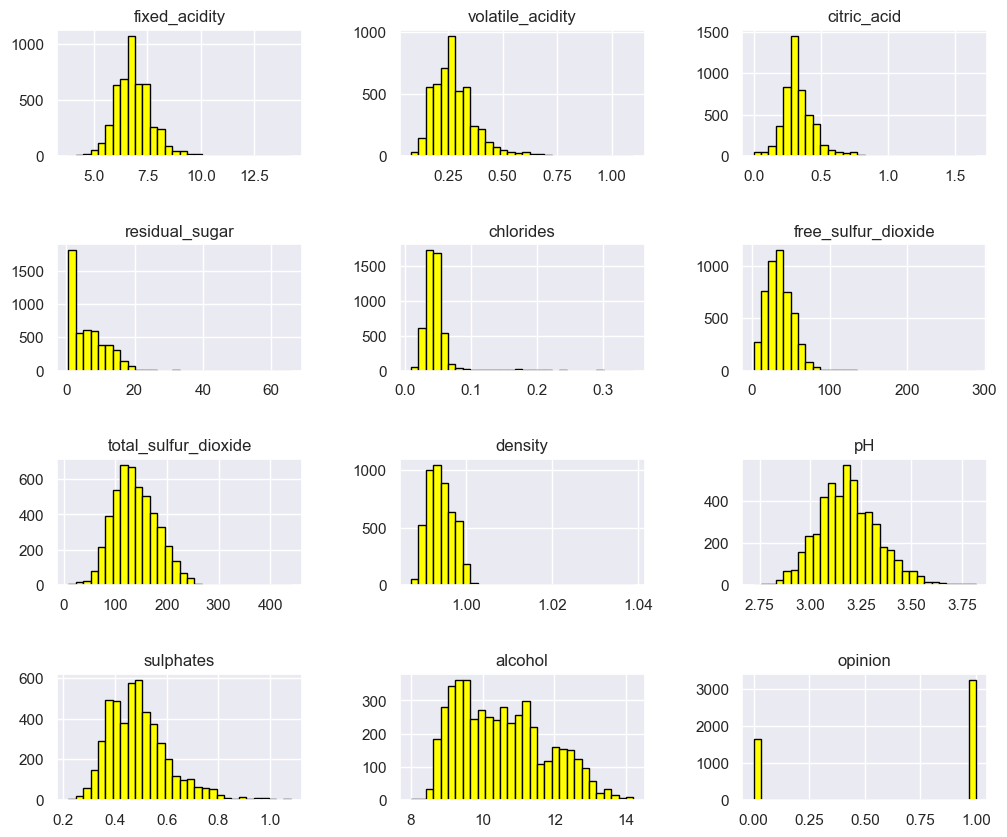

In [233]:
white_dt.hist(figsize=(12, 10), bins=30, edgecolor="black",color='yellow')
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [234]:
white_dt.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.856121          0.278340     0.334114        6.392862   
std         0.843244          0.100766     0.121149        5.071275   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045783            35.308085            138.360657     0.994027   
std       0.021846            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      opinion  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188246     0.489851    10.514267     0.665169  
std       0.150910     0.114127     1.230621     0.471979  
min       2.720000     0.220000     8.000000     0.000000  
25%       3.090000     0.410000     9.500000     0.000000  
50%       3.180000     0.470000    10.400000     1.000000  
75%       3.280000     0.550000    11.400000     1.000000  
max       3.820000     1.080000    14.200000     1.000000

### Conferindo as assimetrias

In [235]:
skew(white_dt)

array([ 0.64605085,  1.57569211,  1.27290621,  1.07669417,  5.02168608,
        1.40631407,  0.39059018,  0.97747354,  0.45770384,  0.97675751,
        0.48719273, -0.69997262])

Os dados de 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides' e 'free_sulfur_dioxide' estão fora do intervalo [-1, 1] e, portanto, existe uma assimetria.

### Aplicando a transformação logarítmica para lidar com as assimetrias nos dados de vinho branco

In [236]:
white_dt['volatile_acidity'] = np.log10(white_dt['volatile_acidity'])
# white_dt['citric_acid'] = np.log10(white_dt['citric_acid'])          # ESTÁ CAUSANDO ERRO!
white_dt['residual_sugar'] = np.log(white_dt['residual_sugar'])
white_dt['chlorides'] = np.log10(white_dt['chlorides'])
white_dt['free_sulfur_dioxide'] = np.log(white_dt['free_sulfur_dioxide'])

[]

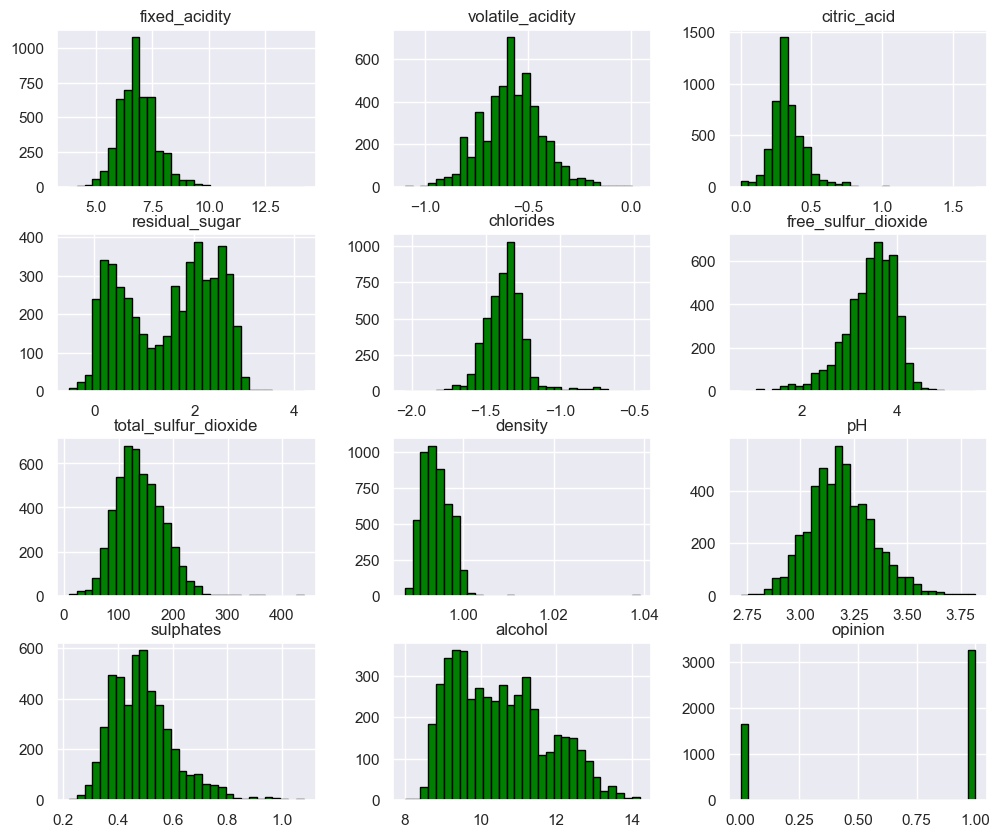

In [237]:
white_dt.hist(figsize=(12, 10), bins=30, edgecolor="black", color='green')
plt.plot()
# plt.subplots_adjust(hspace=0.7, wspace=0.4)

### Conferindo novamente as assimentrias após a aplicação do logarítmo

In [238]:
skew(white_dt)

array([ 0.64605085,  0.13828676,  1.27290621, -0.16222283,  1.13348768,
       -0.93603533,  0.39059018,  0.97747354,  0.45770384,  0.97675751,
        0.48719273, -0.69997262])

### Verificando o balanceamento dos dados

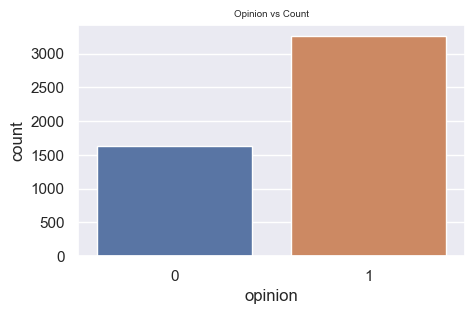

In [239]:
plt.figure(figsize=(5,3))
sns.set(font_scale=1)
plt.title("Opinion vs Count",fontsize=7)
sns.countplot(x=(white_dt['opinion']));

Conforme observado, o dataset está desbalanciado

### Calculando a média e o desvio padrão

In [240]:
# análise descritiva - estatísticas básicas
white_dt.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.856121         -0.580722     0.334114        1.481367   
std         0.843244          0.146794     0.121149        0.921581   
min         3.800000         -1.096910     0.000000       -0.510826   
25%         6.300000         -0.677781     0.270000        0.530628   
50%         6.800000         -0.585027     0.320000        1.648659   
75%         7.300000         -0.494850     0.390000        2.292535   
max        14.200000          0.041393     1.660000        4.186620   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean     -1.367488             3.434852            138.360657     0.994027   
std       0.143823             0.547532             42.498065     0.002991   
min      -2.045757             0.693147              9.000000     0.987110   
25%      -1.443697             3.135494            108.000000     0.991723   
50%      -1.366532             3.526361            134.000000     0.993740   
75%      -1.301030             3.828641            167.000000     0.996100   
max      -0.460924             5.666427            440.000000     1.038980   

                pH    sulphates      alcohol      opinion  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188246     0.489851    10.514267     0.665169  
std       0.150910     0.114127     1.230621     0.471979  
min       2.720000     0.220000     8.000000     0.000000  
25%       3.090000     0.410000     9.500000     0.000000  
50%       3.180000     0.470000    10.400000     1.000000  
75%       3.280000     0.550000    11.400000     1.000000  
max       3.820000     1.080000    14.200000     1.000000

### Verificando a correlação entre variáveis

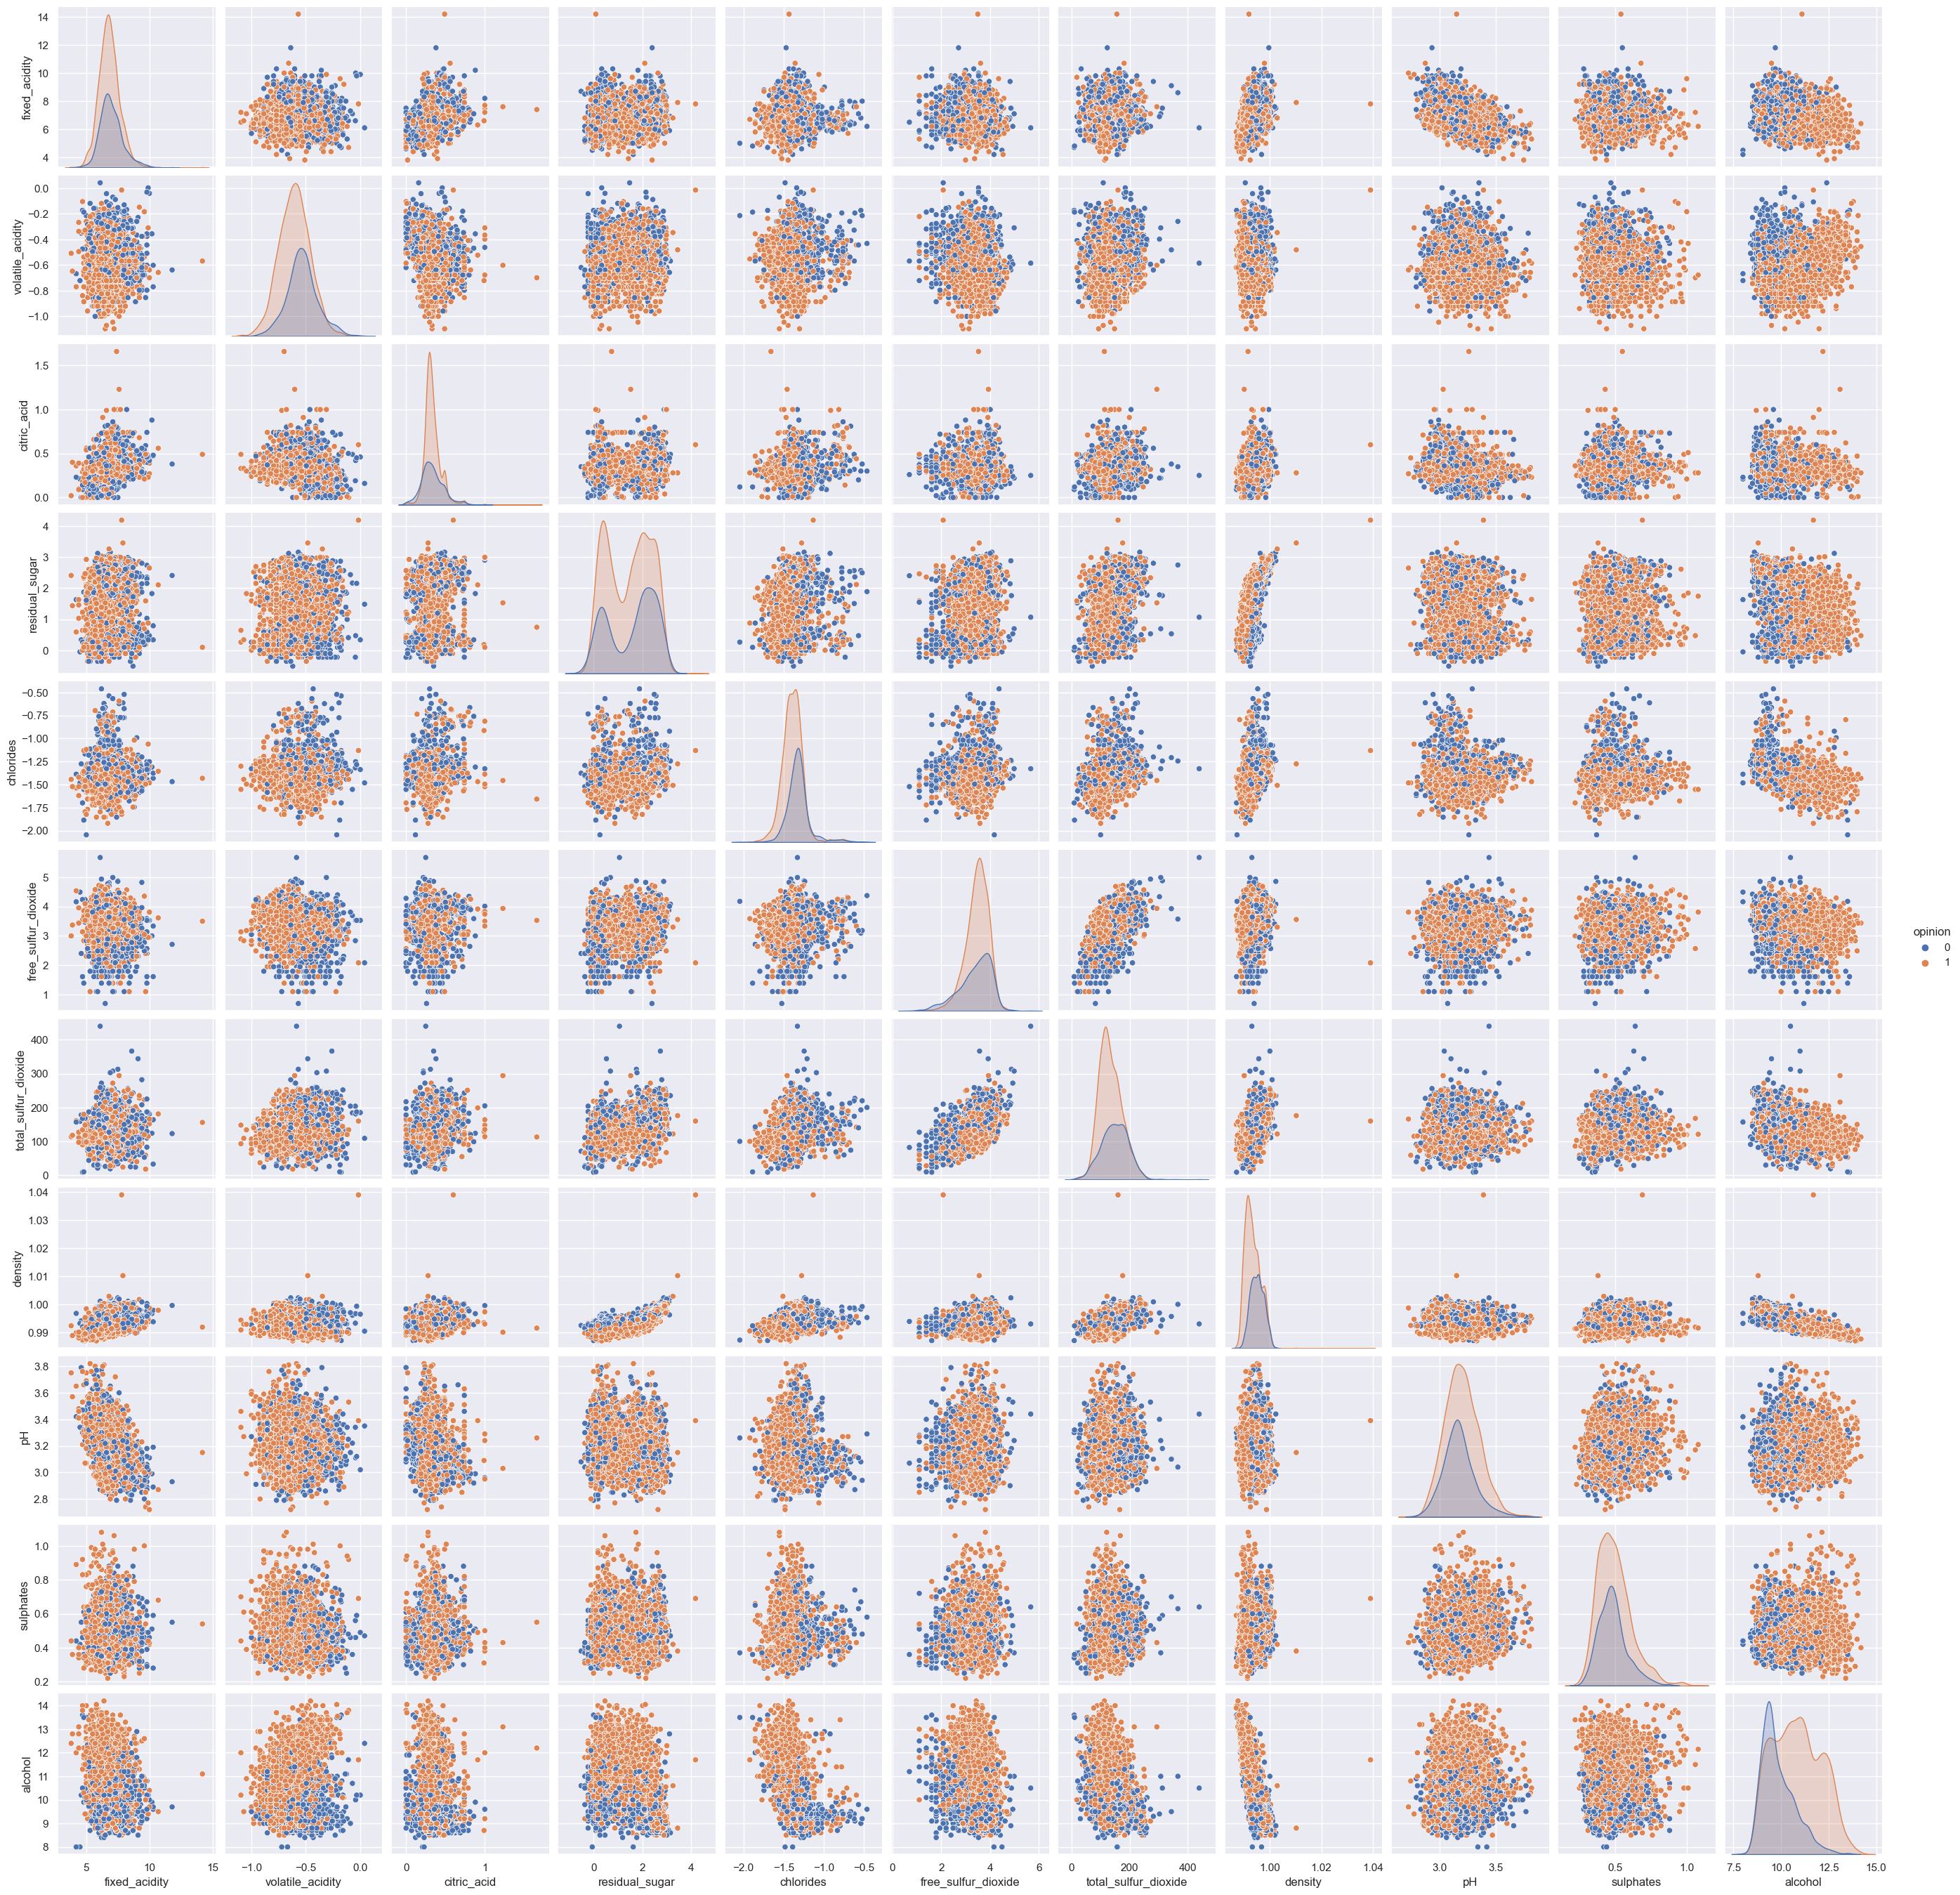

In [241]:
sns.pairplot(white_dt, hue='opinion')

Aparentemente, nenhuma das combinações de variáveis 2x2 apresenta separabilidade linear.

In [242]:
white_dt.corr(numeric_only=True)

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.023825     0.287011   
volatile_acidity          -0.023825          1.000000    -0.133173   
citric_acid                0.287011         -0.133173     1.000000   
residual_sugar             0.070082          0.116828     0.063168   
chlorides                  0.054793          0.034558     0.102030   
free_sulfur_dioxide       -0.058249         -0.097178     0.083791   
total_sulfur_dioxide       0.090705          0.118996     0.120017   
density                    0.265318          0.027650     0.148543   
pH                        -0.424043         -0.055147    -0.162463   
sulphates                 -0.016830         -0.041938     0.061923   
alcohol                   -0.121148          0.067364    -0.074842   
opinion                   -0.090626         -0.232963    -0.000047   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity               0.070082   0.054793            -0.058249   
volatile_acidity            0.116828   0.034558            -0.097178   
citric_acid                 0.063168   0.102030             0.083791   
residual_sugar              1.000000   0.148859             0.323527   
chlorides                   0.148859   1.000000             0.136515   
free_sulfur_dioxide         0.323527   0.136515             1.000000   
total_sulfur_dioxide        0.418760   0.299907             0.596200   
density                     0.756379   0.394819             0.282822   
pH                         -0.175862  -0.069281             0.022317   
sulphates                  -0.031655   0.043988             0.060863   
alcohol                    -0.393978  -0.500659            -0.224092   
opinion                    -0.066971  -0.234105             0.072495   

                      total_sulfur_dioxide   density        pH  sulphates  \
fixed_acidity                     0.090705  0.265318 -0.424043  -0.016830   
volatile_acidity                  0.118996  0.027650 -0.055147  -0.041938   
citric_acid                       0.120017  0.148543 -0.162463   0.061923   
residual_sugar                    0.418760  0.756379 -0.175862  -0.031655   
chlorides                         0.299907  0.394819 -0.069281   0.043988   
free_sulfur_dioxide               0.596200  0.282822  0.022317   0.060863   
total_sulfur_dioxide              1.000000  0.529881  0.002793   0.134583   
density                           0.529881  1.000000 -0.093117   0.074540   
pH                                0.002793 -0.093117  1.000000   0.155897   
sulphates                         0.134583  0.074540  0.155897   1.000000   
alcohol                          -0.448892 -0.780138  0.120985  -0.017482   
opinion                          -0.170924 -0.268696  0.083391   0.051768   

                       alcohol   opinion  
fixed_acidity        -0.121148 -0.090626  
volatile_acidity      0.067364 -0.232963  
citric_acid          -0.074842 -0.000047  
residual_sugar       -0.393978 -0.066971  
chlorides            -0.500659 -0.234105  
free_sulfur_dioxide  -0.224092  0.072495  
total_sulfur_dioxide -0.448892 -0.170924  
density              -0.780138 -0.268696  
pH                    0.120985  0.083391  
sulphates            -0.017482  0.051768  
alcohol               1.000000  0.383280  
opinion               0.383280  1.000000

[]

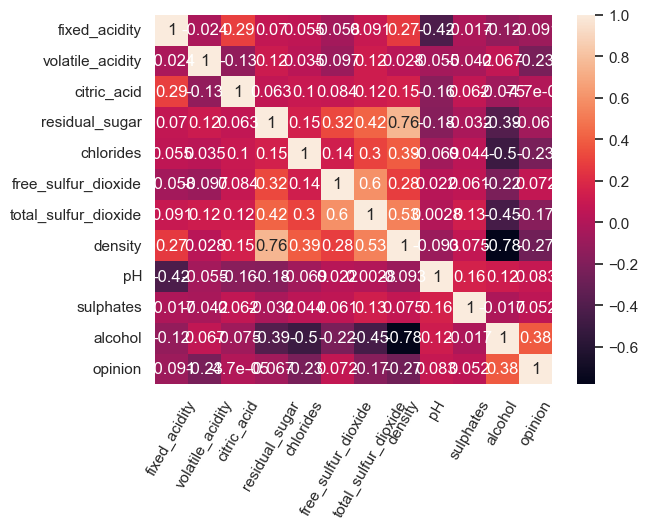

In [243]:
fig, ax = plt.subplots()

sns.heatmap(white_dt.corr(numeric_only=True), annot=True)
ax.tick_params(axis='x', labelrotation=60)
plt.plot()


Considerando altas as correlações entre variáveis >= 0.75 ou <= -0.75:
- 'density' possui uma alta correlação negativa com 'alcohol' e uma correlação positiva com 'residual_sugar'.

Em razão disso, a variável 'density' será excluída dos modelos, para reduzir seu impacto no resultado.

# Modelalgem dos dados

In [244]:
# criando X e y
y = white_dt[['opinion']].values.ravel()
X = white_dt.drop(columns=['opinion', 'density'])

# separando treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [245]:
# criando o pipeline
def pipeline(X, y, sampler, modelo, cv=None):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('sampler', sampler),
        ('model', modelo)
        ])
    
    scores = cross_validate(pipe,
                            X, y,
                            cv=skf, 
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision'],
                            n_jobs=-2
                            )
    
    return scores


# definindo os samplers
samplers = {
    "RUS": RandomUnderSampler(random_state=7),
    "ROS": RandomOverSampler(random_state=7)
    }


# definindo os modelos
modelos = {
    'LogisticRegression': LogisticRegression(random_state=7),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=7),
    'SVC': SVC(probability=True, random_state=7)
}


# criando um modelo de validação cruzada estratificada com StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [246]:
# agrupando os resultados dos modelos com RandomUnderSampler
resultados_rus = {
    "LogisticRegression": pipeline(X_train, y_train, samplers["RUS"], modelos["LogisticRegression"], skf),
    "DecisionTreeClassifier": pipeline(X_train, y_train, samplers["RUS"], modelos["DecisionTreeClassifier"], skf),
    "SVC": pipeline(X_train, y_train, samplers["RUS"], modelos["SVC"], skf),
}

In [247]:
# agrupando os resultados dos modelos com RandomOverSampler
resultados_ros = {
    "LogisticRegression": pipeline(X_train, y_train, samplers["ROS"], modelos["LogisticRegression"], skf),
    "DecisionTreeClassifier": pipeline(X_train, y_train, samplers["ROS"], modelos["DecisionTreeClassifier"], skf),
    "SVC": pipeline(X_train, y_train, samplers["ROS"], modelos["SVC"], skf),
}

In [248]:
# criando DataFrames para a avaliação dos modelos em cada um dos samplers
df_rus = pd.DataFrame(resultados_rus).T.assign(sampler='RUS').reset_index().rename(columns={'index': 'model'})
df_ros = pd.DataFrame(resultados_ros).T.assign(sampler='ROS').reset_index().rename(columns={'index': 'model'})
df_results = pd.concat([df_rus, df_ros]).reset_index(drop=True)

In [249]:
df_rslt_exp = df_results.explode(df_results.columns[1:-1].tolist()).reset_index(drop=True)
df_rslt_exp = df_rslt_exp.assign(time = df_rslt_exp['fit_time'] + df_rslt_exp['score_time'])
df_rslt_exp = df_rslt_exp.apply(pd.to_numeric, errors = 'ignore')
df_rslt_exp

model  fit_time  score_time  test_accuracy  \
0       LogisticRegression  0.014107    0.003659       0.734694   
1       LogisticRegression  0.012305    0.009514       0.691327   
2       LogisticRegression  0.015112    0.003767       0.719388   
3       LogisticRegression  0.014183    0.004316       0.696429   
4       LogisticRegression  0.014228    0.009353       0.770408   
5       LogisticRegression  0.013824    0.007052       0.691327   
6       LogisticRegression  0.016486    0.003644       0.729592   
7       LogisticRegression  0.009039    0.003579       0.706633   
8       LogisticRegression  0.009854    0.011257       0.731458   
9       LogisticRegression  0.004199    0.003358       0.728900   
10  DecisionTreeClassifier  0.012029    0.003474       0.727041   
11  DecisionTreeClassifier  0.011956    0.003290       0.729592   
12  DecisionTreeClassifier  0.011994    0.005073       0.729592   
13  DecisionTreeClassifier  0.013027    0.008993       0.693878   
14  DecisionTreeClassifier  0.011523    0.003578       0.750000   
15  DecisionTreeClassifier  0.014157    0.003337       0.701531   
16  DecisionTreeClassifier  0.015703    0.003570       0.732143   
17  DecisionTreeClassifier  0.012478    0.003963       0.704082   
18  DecisionTreeClassifier  0.011550    0.004248       0.721228   
19  DecisionTreeClassifier  0.011741    0.004430       0.695652   
20                     SVC  0.528945    0.039979       0.772959   
21                     SVC  0.566931    0.043777       0.750000   
22                     SVC  0.483531    0.061179       0.734694   
23                     SVC  0.516844    0.042956       0.737245   
24                     SVC  0.527085    0.044102       0.765306   
25                     SVC  0.516522    0.049624       0.727041   
26                     SVC  0.585878    0.043093       0.732143   
27                     SVC  0.539203    0.063464       0.752551   
28                     SVC  0.503691    0.060862       0.759591   
29                     SVC  0.356884    0.039202       0.757033   
30      LogisticRegression  0.005383    0.004415       0.729592   
31      LogisticRegression  0.004898    0.003562       0.688776   
32      LogisticRegression  0.005406    0.005996       0.724490   
33      LogisticRegression  0.004735    0.003164       0.698980   
34      LogisticRegression  0.005076    0.003286       0.760204   
35      LogisticRegression  0.007123    0.004145       0.691327   
36      LogisticRegression  0.005068    0.003243       0.729592   
37      LogisticRegression  0.005476    0.003378       0.714286   
38      LogisticRegression  0.010138    0.006397       0.726343   
39      LogisticRegression  0.006792    0.006129       0.723785   
40  DecisionTreeClassifier  0.023747    0.004118       0.778061   
41  DecisionTreeClassifier  0.021581    0.003341       0.760204   
42  DecisionTreeClassifier  0.021790    0.006209       0.785714   
43  DecisionTreeClassifier  0.022829    0.005497       0.772959   
44  DecisionTreeClassifier  0.031546    0.003385       0.760204   
45  DecisionTreeClassifier  0.025782    0.003326       0.744898   
46  DecisionTreeClassifier  0.020541    0.003331       0.739796   
47  DecisionTreeClassifier  0.021149    0.004891       0.780612   
48  DecisionTreeClassifier  0.021544    0.003857       0.749361   
49  DecisionTreeClassifier  0.020059    0.004420       0.769821   
50                     SVC  1.856593    0.085144       0.778061   
51                     SVC  1.880740    0.110719       0.752551   
52                     SVC  1.944737    0.105543       0.747449   
53                     SVC  1.801482    0.116082       0.757653   
54                     SVC  1.881364    0.103649       0.775510   
55                     SVC  1.976443    0.091424       0.739796   
56                     SVC  1.947743    0.105311       0.755102   
57                     SVC  1.799275    0.088547       0.772959   
58                     SVC  1.965132    0.087406       0.762148   
5

# Avaliando os modelos

### Calculando a Acurácia

In [250]:
for i, acu in enumerate(df_results['test_accuracy']):
    mean_accuracy = np.mean(acu)
    print(f"Ao realizar a {df_results['model'][i]} com o sampler {df_results['sampler'][i]}, o resultado da Acurácia média de treino foi de {mean_accuracy}.")

Ao realizar a LogisticRegression com o sampler RUS, o resultado da Acurácia média de treino foi de 0.7200153974633332.
Ao realizar a DecisionTreeClassifier com o sampler RUS, o resultado da Acurácia média de treino foi de 0.7184736938253561.
Ao realizar a SVC com o sampler RUS, o resultado da Acurácia média de treino foi de 0.748856281643092.
Ao realizar a LogisticRegression com o sampler ROS, o resultado da Acurácia média de treino foi de 0.7187372775197034.
Ao realizar a DecisionTreeClassifier com o sampler ROS, o resultado da Acurácia média de treino foi de 0.7641630565269587.
Ao realizar a SVC com o sampler ROS, o resultado da Acurácia média de treino foi de 0.7590590584059711.


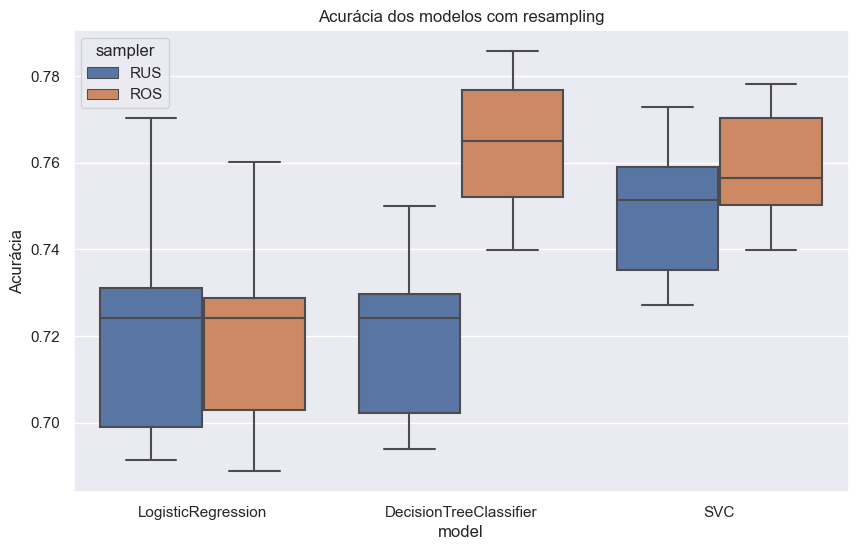

In [251]:
fig, ax = plt.subplots(figsize=(10,6))

sns. boxplot(
    data=df_rslt_exp, x= 'model',
    y='test_accuracy', hue='sampler', ax=ax
)
ax. set_title('Acurácia dos modelos com resampling')
ax.set_ylabel('Acurácia')

plt.show()

O Decision Tree com o RandomOverSampler foi o modelo que obteve o melhor desempenho de Acurácia, atingindo pouco mais de 0.76.

O SVC teve um desempenho próximo com o RandomOverSampler, de cerca de 0.76.

### Calculando a Precisão

In [252]:
for i, pre in enumerate(df_results['test_precision']):
    mean_precision = np.mean(pre)
    print(f"Ao realizar a {df_results['model'][i]} com o sampler {df_results['sampler'][i]}, o resultado da Precisão média de treino foi de {mean_precision}.")

Ao realizar a LogisticRegression com o sampler RUS, o resultado da Precisão média de treino foi de 0.8464733468283512.
Ao realizar a DecisionTreeClassifier com o sampler RUS, o resultado da Precisão média de treino foi de 0.842472974055571.
Ao realizar a SVC com o sampler RUS, o resultado da Precisão média de treino foi de 0.8644949839951392.
Ao realizar a LogisticRegression com o sampler ROS, o resultado da Precisão média de treino foi de 0.844645813625007.
Ao realizar a DecisionTreeClassifier com o sampler ROS, o resultado da Precisão média de treino foi de 0.818508877497923.
Ao realizar a SVC com o sampler ROS, o resultado da Precisão média de treino foi de 0.8607667386737106.


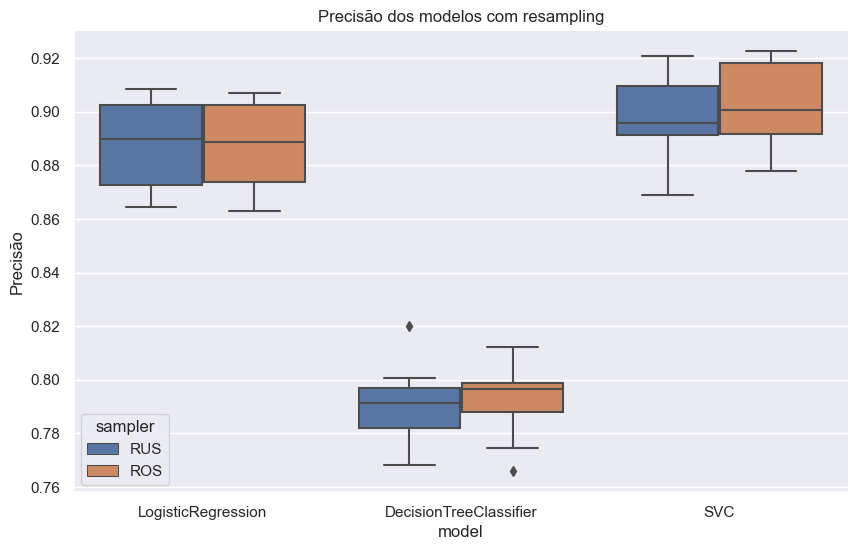

In [253]:
fig, ax = plt.subplots(figsize=(10,6))

sns. boxplot(
    data=df_rslt_exp, x= 'model',
    y='test_average_precision', hue='sampler', ax=ax
)
ax. set_title('Precisão dos modelos com resampling')
ax.set_ylabel('Precisão')

plt.show()

O SVC com o RandomUnderSampler foi o modelo que obteve o melhor desempenho médio de Precisão, atingindo pouco mais de 0.86.

Com o RandomOverSampler, o SVC teve um desempenho médio de 0.86.

### Calculando o Recall

In [254]:
for i, rec in enumerate(df_results['test_recall']):
    mean_recall = np.mean(rec)
    print(f"Ao realizar a {df_results['model'][i]} com o sampler {df_results['sampler'][i]}, o resultado da Recall médio de treino foi de {mean_recall}.")

Ao realizar a LogisticRegression com o sampler RUS, o resultado da Recall médio de treino foi de 0.7079796640141469.
Ao realizar a DecisionTreeClassifier com o sampler RUS, o resultado da Recall médio de treino foi de 0.7102799882110228.
Ao realizar a SVC com o sampler RUS, o resultado da Recall médio de treino foi de 0.7386766872973769.
Ao realizar a LogisticRegression com o sampler ROS, o resultado da Recall médio de treino foi de 0.7079840848806367.
Ao realizar a DecisionTreeClassifier com o sampler ROS, o resultado da Recall médio de treino foi de 0.8300000000000001.
Ao realizar a SVC com o sampler ROS, o resultado da Recall médio de treino foi de 0.7616976127320955.


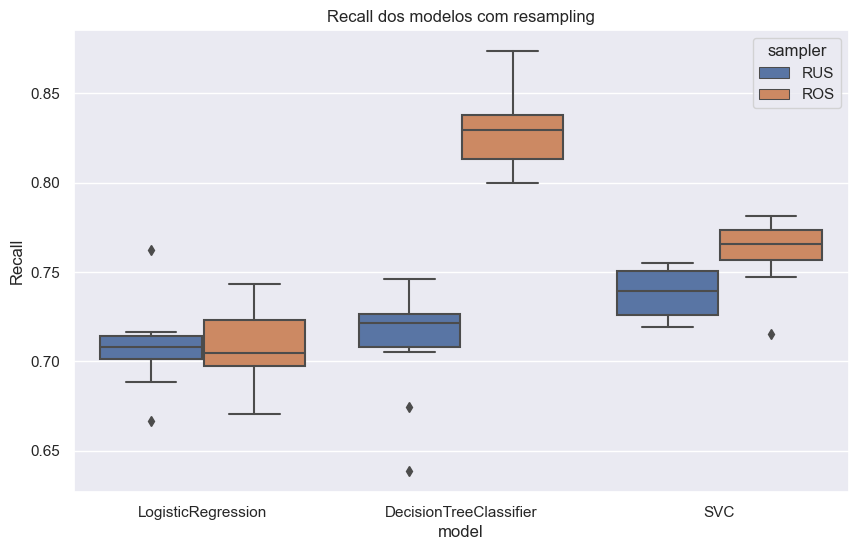

In [255]:
fig, ax = plt.subplots(figsize=(10,6))

sns. boxplot(
    data=df_rslt_exp, x= 'model',
    y='test_recall', hue='sampler', ax=ax
)
ax. set_title('Recall dos modelos com resampling')
ax.set_ylabel('Recall')

plt.show()

O Decision Tree com o RandomOverSampler foi o modelo que obteve o melhor desempenho médio de Recall, de 0.83.

O SVC teve um desempenho médio com o RandomOverSampler, de cerca de 0.76.

### Calculando o F1-Score

In [256]:
for i, f1 in enumerate(df_results['test_f1']):
    mean_f1 = np.mean(f1)
    print(f"Ao realizar a {df_results['model'][i]} com o sampler {df_results['sampler'][i]}, o resultado do F1-Score médio de treino foi de {mean_f1}.")

Ao realizar a LogisticRegression com o sampler RUS, o resultado do F1-Score médio de treino foi de 0.7707852523473113.
Ao realizar a DecisionTreeClassifier com o sampler RUS, o resultado do F1-Score médio de treino foi de 0.7701758592897409.
Ao realizar a SVC com o sampler RUS, o resultado do F1-Score médio de treino foi de 0.7964714435319453.
Ao realizar a LogisticRegression com o sampler ROS, o resultado do F1-Score médio de treino foi de 0.7700126030664178.
Ao realizar a DecisionTreeClassifier com o sampler ROS, o resultado do F1-Score médio de treino foi de 0.8239500549446802.
Ao realizar a SVC com o sampler ROS, o resultado do F1-Score médio de treino foi de 0.8078648231993732.


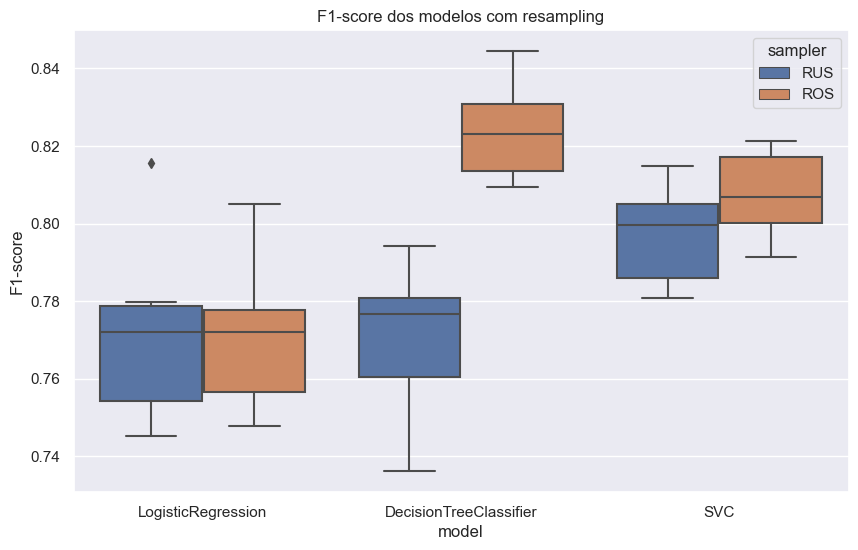

In [257]:
fig, ax = plt.subplots(figsize=(10,6))

sns. boxplot(
    data=df_rslt_exp, x= 'model',
    y='test_f1', hue='sampler', ax=ax
)
ax. set_title('F1-score dos modelos com resampling')
ax.set_ylabel('F1-score')

plt.show()

O Decision Tree com o RandomOverSampler foi o modelo que obteve o melhor desempenho médio de F1-Score, atingindo pouco mais de 0.82.

O SVC teve um desempenho médio próximo com o RandomOverSampler, de cerca de 0.81.

### Avaliando o tempo de resampling

In [258]:
fig, ax = plt.subplots(figsize=(10,6))

sns. barplot(
    data=df_rslt_exp, x= 'model',
    y='time', hue='sampler', ax=ax
)
ax. set_title('Tempo de execução dos modelos com resampling (RUS ou ROS)')
ax.set_ylabel('Tempo de execução')


plt.show()

Apesar de o tempo de execução do RandomOverSampler ser maior, especialmente no SVC, o ganho de desempenho nos testes faz com que optemos pela sua utilização na otimização dos hiperparâmetros.

# Otimizando os hiperparâmetros

In [271]:
def pipe_param(X, y, modelo, cv=None):
    pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('sampler', RandomOverSampler(random_state=7)),
            ('model', modelo)
            ])

    if modelo == modelos['LogisticRegression']:
        param_grid = {
            'model__C': np.logspace(-3, 3, 7),
            'model__penalty': ['l1', 'l2', 'elasticnet', None],
            'model__solver': ['lbfgs', 'saga']
        }
    
    elif modelo == modelos['DecisionTreeClassifier']:
        param_grid = {
            'model__criterion': ['gini', 'entropy', 'log_loss'],
            'model__max_depth': range(2, 50)
        }
    
    elif modelo == modelos['SVC']:
        param_grid = {
            'model__kernel': ['rbf', 'sigmoid', 'cosine', 'linear'],
            'model__C': np.logspace(-3, 3, 7),
            'model__gamma': np.logspace(-3, 3, 7),
        }

    grid_search = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        refit='precision', #Considerando que o teste de precisão apresentou o resultado mais promissor, utilizaremos ele par o refit
        cv=skf,
        n_jobs=-2
    )

    grid_search.fit(X, y)

    return grid_search

In [272]:
best_LR = pipe_param(X_train, y_train, modelos["LogisticRegression"], skf)

/Users/victorvieira/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victorvieira/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victorvieira/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victorvieira/anaconda3/lib/python3.11/site-packages/sklearn/met

In [273]:
# melhores hiperparâmetros para a Regressão Logística
best_LR.best_params_

{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga'}

In [275]:
best_DT = pipe_param(X_train, y_train, modelos["DecisionTreeClassifier"], skf)

In [276]:
# melhores hiperparâmetros para a Árvore de Decisão
best_DT.best_params_

{'model__criterion': 'entropy', 'model__max_depth': 5}

In [278]:
best_SVC = pipe_param(X_train, y_train, modelos["SVC"], skf)

In [279]:
# melhores hiperparâmetros para a SVC
best_SVC.best_params_

{'model__C': 0.01, 'model__gamma': 0.1, 'model__kernel': 'rbf'}

In [274]:
# avaliação da Regressão Logística com os hiperparâmetros otimizados
print(f'''Os novos resultados da Regressão Logística após a otimização dos hiperparâmetros são:
      Acurácia média: {np.nanmax(best_LR.cv_results_['mean_test_accuracy'])} 
      Precisão média: {np.nanmax(best_LR.cv_results_['mean_test_precision'])} 
      Recall médio: {np.nanmax(best_LR.cv_results_['mean_test_recall'])} 
      F1-score médio: {np.nanmax(best_LR.cv_results_['mean_test_f1'])}
      ''')

Os novos resultados da Regressão Logística após a otimização dos hiperparâmetros são:
      Acurácia média: 0.7187372775197034 
      Precisão média: 0.845098639916564 
      Recall médio: 0.7079840848806367 
      F1-score médio: 0.7700126030664178
      


In [277]:
# avaliação da Árvore de Decisão com os hiperparâmetros otimizados
print(f'''Os novos resultados da Árvore de Decisão após a otimização dos hiperparâmetros são:
      Acurácia média: {np.nanmax(best_DT.cv_results_['mean_test_accuracy'])} 
      Precisão média: {np.nanmax(best_DT.cv_results_['mean_test_precision'])} 
      Recall médio: {np.nanmax(best_DT.cv_results_['mean_test_recall'])} 
      F1-score médio: {np.nanmax(best_DT.cv_results_['mean_test_f1'])}
      ''')

Os novos resultados da Árvore de Decisão após a otimização dos hiperparâmetros são:
      Acurácia média: 0.7779574873427632 
      Precisão média: 0.852042212832222 
      Recall médio: 0.8311523725316828 
      F1-score médio: 0.8322141985479341
      


In [280]:
# avaliação do SVC com os hiperparâmetros otimizados
print(f'''Os novos resultados de SVC após a otimização dos hiperparâmetros são:
      Acurácia média: {np.nanmax(best_SVC.cv_results_['mean_test_accuracy'])} 
      Precisão média: {np.nanmax(best_SVC.cv_results_['mean_test_precision'])} 
      Recall médio: {np.nanmax(best_SVC.cv_results_['mean_test_recall'])} 
      F1-score médio: {np.nanmax(best_SVC.cv_results_['mean_test_f1'])}
      ''')

Os novos resultados de SVC após a otimização dos hiperparâmetros são:
      Acurácia média: 0.7940321780886268 
      Precisão média: 0.8712227575768849 
      Recall médio: 1.0 
      F1-score médio: 0.8559680588662297
      


### Traçando a Curva ROC

In [329]:
# curva ROC da Regressão Logística
ypred_test_LR = best_LR.best_estimator_.predict_proba(X_test)[:, 1]
fpr_LR, tpr_LR, thresholds = metrics.roc_curve(y_test, ypred_test_LR)

# curva ROC da Árvore de Decisão
ypred_test_DT = best_DT.best_estimator_.predict_proba(X_test)[:, 1]
fpr_DT, tpr_DT, thresholds = metrics.roc_curve(y_test, ypred_test_DT)

# curva ROC do SVC
ypred_test_SVC = best_SVC.best_estimator_.predict_proba(X_test)[:, 1]
fpr_SVC, tpr_SVC, thresholds = metrics.roc_curve(y_test, ypred_test_SVC)

In [330]:
# plotando a curva ROC média dos modelos
plt.plot(fpr_LR, tpr_LR, label=f"Regressão Logística (AUC = {np.nanmax(best_LR.cv_results_['mean_test_roc_auc']):.3})")
plt.plot(fpr_DT, tpr_DT, label=f"Árvore de Decisão (AUC = {np.nanmax(best_DT.cv_results_['mean_test_roc_auc']):.3}):")
plt.plot(fpr_SVC, tpr_SVC, label=f"SVC (AUC = {np.nanmax(best_SVC.cv_results_['mean_test_roc_auc']):.3})")
plt.plot([0, 1], [0, 1], label='Classificador Aleatório')
plt.title('Curva ROC média dos modelos')
plt.legend(fontsize=8)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.show()

Tomando por base as métricas de acurácia, precisão, recall e f1-score, assim como a curva ROC média, o Classificador de Vetor de Suporte ou Support Vector Classifier (SVC) foi o modelo que apresentou o melhor desempenho para a previsão da "opinion" a partir da análise das características dos vinhos brancos. O SVC superou a Regressão Logística e a Árvore de Decisão em todas as métricas:

<center>

 modelo | Classificador de Vetor de Suporte | Regressão Logística | Árvore de decisão 
 :- | :-: | :-: | :-: 
acurácia | 0.794 | 0.719 | 0.778
precisão | 0.871 | 0.845 | 0.852
recall | 1.0 | 0.708 | 0.831
f1-score | 0.856 | 0.770 | 0.832
área sob a curva ROC| 0.855 | 0.804 | 0.796

<center>


# Utilizando o mesmo modelo para o conjunto de vinhos tintos

In [331]:
# criando X e y
y_red = red_dt[['opinion']].values.ravel()
X_red = red_dt.drop(columns=['opinion', 'density'])

In [344]:
svc_pred_red = best_SVC.best_estimator_.predict(X_red)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

accuracy_list.append(metrics.accuracy_score(y_red, svc_pred_red))
precision_list.append(metrics.precision_score(y_red, svc_pred_red))
recall_list.append(metrics.recall_score(y_red, svc_pred_red))
f1_list.append(metrics.f1_score(y_red, svc_pred_red))


print(f'''Utilizando o modelo SVC com os hiperparâmetros otimizados para os dados de vinhos brancos, e treinado para esses dados, para prever o desempenho dos vinhos tintos, as métricas identificaram:
      Acurácia média: {np.mean(accuracy_list)} 
      Precisão média: {np.mean(precision_list)} 
      Recall médio: {np.mean(recall_list)} 
      F1-score médio: {np.mean(f1_list)}
      ''')

Utilizando o modelo SVC com os hiperparâmetros otimizados para os dados de vinhos brancos, e treinado para esses dados, para prever o desempenho dos vinhos tintos, as métricas identificaram:
      Acurácia média: 0.4652908067542214 
      Precisão média: 0.0 
      Recall médio: 0.0 
      F1-score médio: 0.0
      
